In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 

font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta
sns.set_theme()





In [2]:
# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[ np.random.normal(señal[i], señal[i]*desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Funcion para verificar teorema del limite central

    Parametros
    -----------
    s: Arreglo
     Arreglo de datos a los que se quieren aplicar el teorema
    k: float
     Numero de datos para efectuar el promedio

'''

    new_s=[]
    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


# Perspectiva 1.


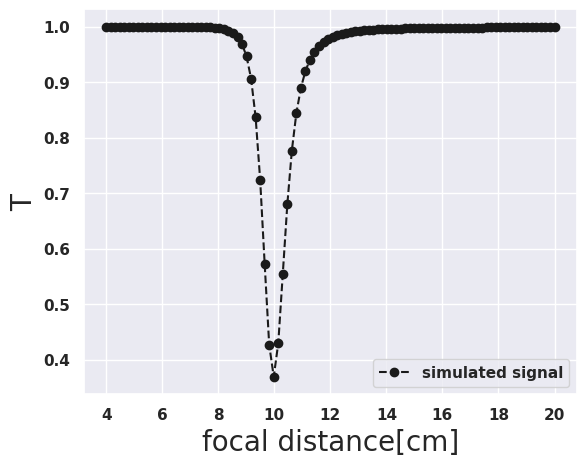

In [3]:
fig=plt.figure(figsize=(14,5))

######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=1e-2*np.linspace(4,20,100) #focal distance [m]
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 100e-3# Distance EFTL-sample (m)a
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ
T=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
#Td= np.gradient(T)

plt.subplot(122)
plt.plot(focal*100,T,'--ko',label='simulated signal')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T',fontsize=20)
plt.xlabel('focal distance[cm]',fontsize=20)
plt.legend()






In [4]:
def dist_betas(N,desv,k): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]

  for ii in range(N):
      
      er=desv/100
      er_L=er*0
      er_P=er
      er_T=er*0
      er_D=er*0
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      
      TPA.append(BETA(T[k],focal[k],L_f,Pavg_f,Tp_f,wl,D_f,ds,Cf,alfa,R,freq)[0]*1e11)
      
    
  return TPA

# Analisis

El resultado muestra que sin importar el error relativo en el regimen Gaussiano, podemos decir que la medida es confiable, ¿tiene esto sentido?



In [5]:
n=index
desvf=[]
muf=[]
er_r=np.linspace(0.005,3,50) #Porcentaje de error
for c in er_r:
    
    beta_hist=np.array(dist_betas(1000,c,n))
    (mu, sigma) = norm.fit(beta_hist)

    muf.append(mu)
    desvf.append(sigma)


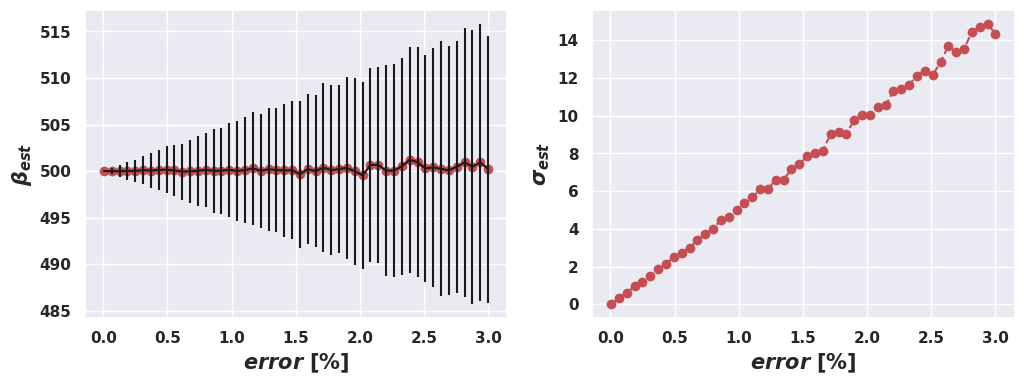

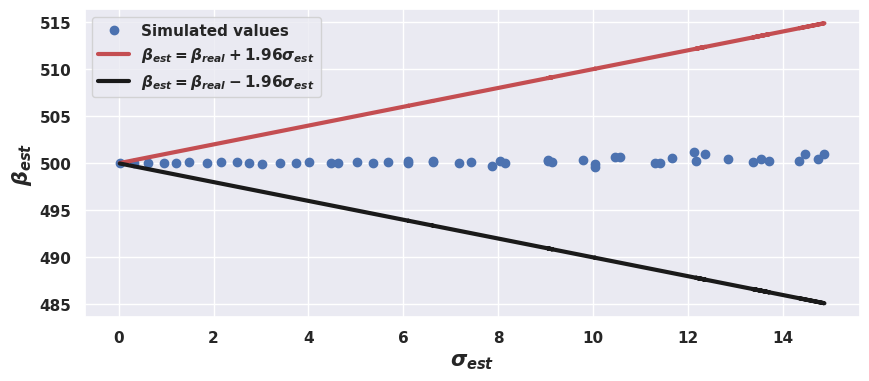

In [6]:
f=plt.figure(figsize=(12,4))

plt.subplot(121)
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)
plt.plot(er_r,muf,'ro')
plt.errorbar(er_r,muf,yerr=desvf,color='k')


plt.subplot(122)
plt.plot(er_r,desvf,'--ro')
plt.ylabel(r'$\sigma_{est}$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)


f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()

# ¿Qué sucede en una situación real donde no tenemos control sobre nuestros errores? Aplicamos el teorema del limite central.


In [7]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,5,50) #Porcentaje de error
N=1000
final=np.zeros((len(er_r),len(focal)))
mus=np.zeros((len(er_r),len(focal)))
sigmas=np.zeros((len(er_r),len(focal)))

for k in range(len(focal)):

    for c,j in enumerate(er_r):

    
        beta_hist=np.array(dist_betas(N,j,k))
        mus[c,k]=np.mean(beta_hist)
        sigmas[c,k]=np.std(beta_hist,ddof=1)/np.sqrt(N)

        if abs(mus[c,k]-beta*1e11)<1.96*sigmas[c,k]:
            final[c,k]=1

        else:
            
            final[c,k]=0
        

# ¿Donde es mejor hacer el analisis?

([<matplotlib.axis.YTick at 0x7f9fc6a85300>,
 [Text(0, 0, '0.005'),
  Text(0, 8, '0.821'),
  Text(0, 16, '1.636'),
  Text(0, 24, '2.452'),
  Text(0, 32, '3.267'),
  Text(0, 40, '4.083'),
  Text(0, 48, '4.898')])

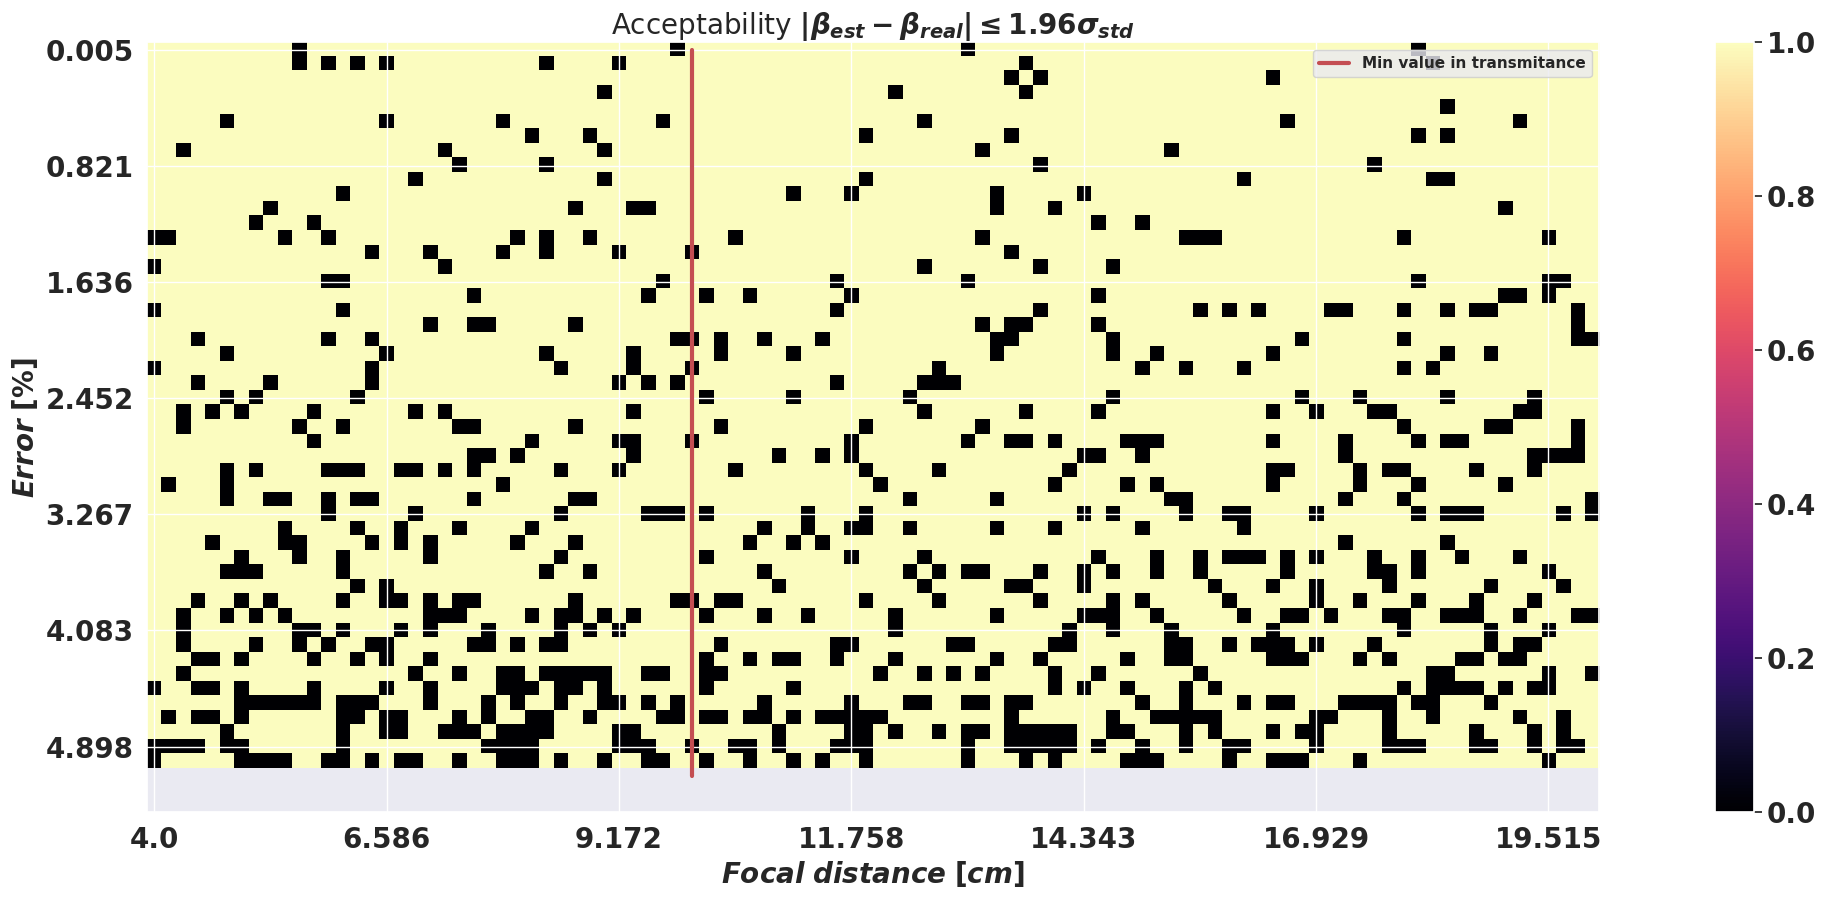

In [8]:
fig = plt.figure(figsize=(30,10))

er_r=np.linspace(0.005,5,50) #Porcentaje de error
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$Error$ $[\%]$',fontsize=20)
plt.xlabel('$Focal$ $distance$ $[cm]$',fontsize=20)
plt.title(r'Acceptability $\left | \beta_{est}-\beta_{real} \right |\leq 1.96 \sigma_{std}$',fontsize=20)
plt.legend()
plt.colorbar()

nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round(100*focal[::step_x],3) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)


ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


# ¿Como es la medida?

Text(0, 0.5, '$\\beta_{est}$ $[cm/GW]$')

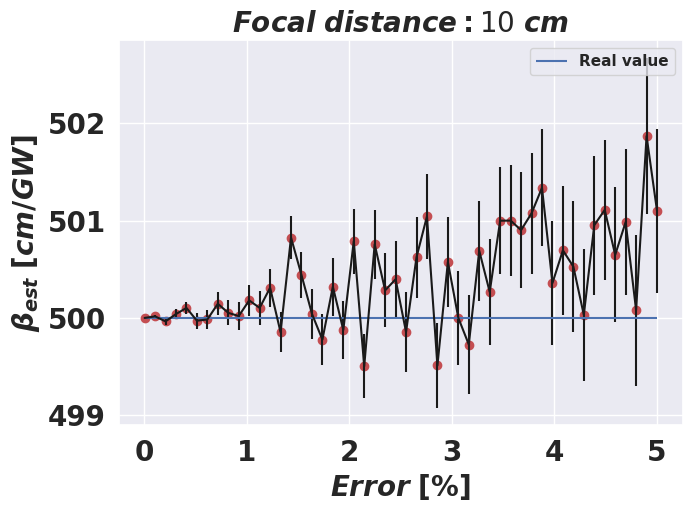

In [9]:
n=index
f=plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(er_r,mus[:,n],'ro')
plt.errorbar(er_r,mus[:,n],yerr=sigmas[:,n],color='k')
plt.hlines(beta*1e11,xmin=min(er_r),xmax=max(er_r),label='Real value')
plt.xlabel('$Error$ $[\%]$',fontsize=20)
plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$',fontsize=20)
plt.legend()

plt.ylabel(r'$\beta_{est}$ $[cm/GW]$',fontsize=20)



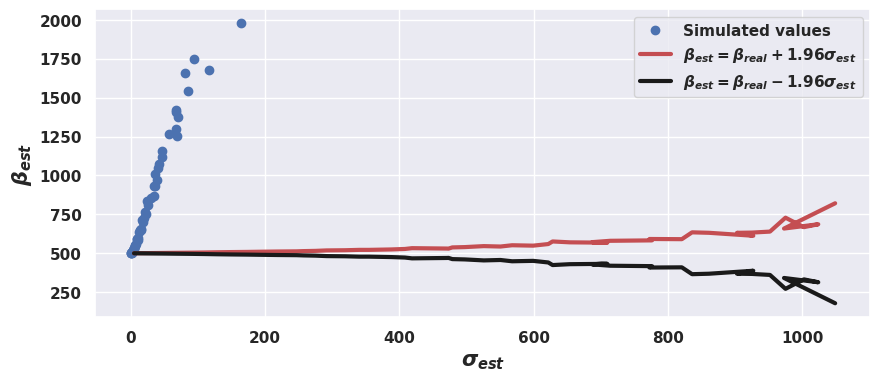

In [217]:
f=plt.figure(figsize=(10,4))
er_r=np.linspace(0.005,5,50) #Porcentaje de error
plt.plot(sigmas[:,-n],mus[:,-n],'o',label='Simulated values')
y1=beta*1e11+1.96*sigmas[:,-n]
y2=beta*1e11-1.96*sigmas[:,-n]
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()


# Analisis perspectiva 2.

In [10]:
# Función ajustar
def BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]

  for ii in range(N):
      
      er=desv/100
      er_L=er*0
      er_P=er
      er_T=er*0
      er_D=er*0
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      
      TPA.append(BETA2(T,focal,L_f,Pavg_f,Tp_f,wl,D_f,ds,Cf,alfa,R,freq)*1e11)
      
    
  return TPA


In [11]:
muf=[]
desvf=[]
er_r=np.linspace(0.005,5,50) #Porcentaje de error
decis=[]

for j in er_r:
    
    
    beta_hist=np.array(dist_betas2(1000,j))
    (mu, sigma) = norm.fit(beta_hist)
    muf.append(mu)
    desvf.append(sigma)

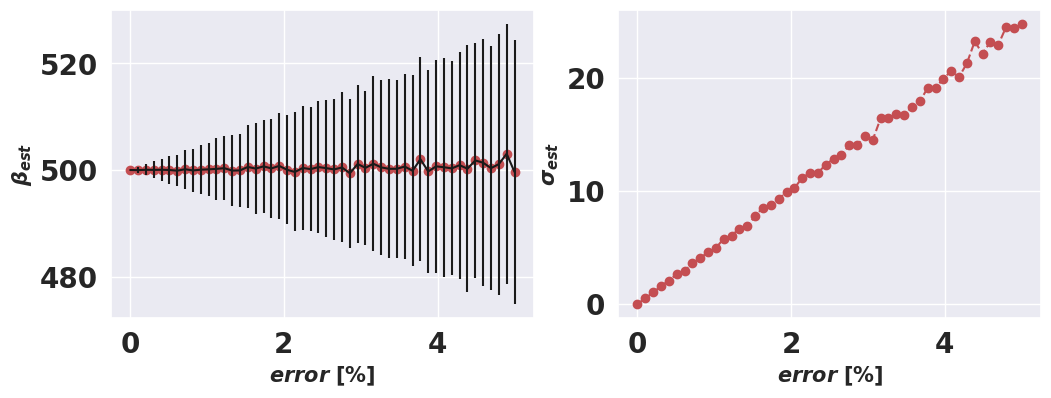

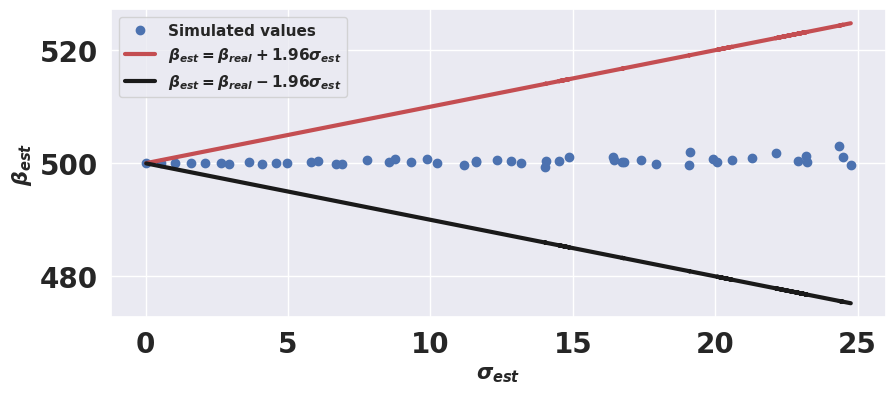

In [12]:
f=plt.figure(figsize=(12,4))

plt.subplot(121)
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)
plt.plot(er_r,muf,'ro')
plt.errorbar(er_r,muf,yerr=desvf,color='k')


plt.subplot(122)
plt.plot(er_r,desvf,'--ro')
plt.ylabel(r'$\sigma_{est}$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)


f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()

# Analisis teorema de limite central

In [13]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,5,50) #Porcentaje de error
N=100
mus=[]
sigmas=[]
dec=[]

for c,j in enumerate(er_r):


    beta_hist=np.array(dist_betas2(N,j))
    mus.append(np.mean(beta_hist))
    sigmas.append(np.std(beta_hist,ddof=1)/np.sqrt(N))

    if abs(mus[c]-beta*1e11)<1.96*sigmas[c]:
        dec.append(1)

    else:
        
        dec.append(0)

Text(0, 0.5, '$\\beta_{est}$ $[cm/GW]$')

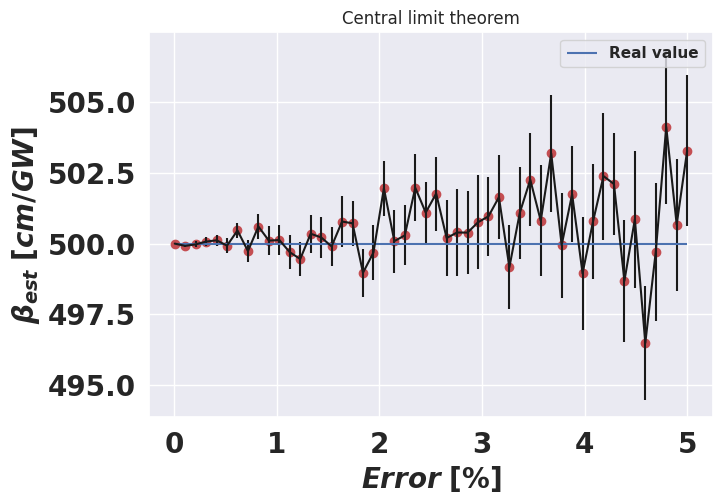

In [14]:

f=plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(er_r,mus,'ro')
plt.errorbar(er_r,mus,yerr=sigmas,color='k')
plt.hlines(beta*1e11,xmin=min(er_r),xmax=max(er_r),label='Real value')
plt.xlabel('$Error$ $[\%]$',fontsize=20)
plt.legend()
plt.title('Central limit theorem')
plt.ylabel(r'$\beta_{est}$ $[cm/GW]$',fontsize=20)

